In [1]:
# Environment
import gym

# Neural Network 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Data structures
import numpy as np
from collections import deque
import copy

# For loop and while loop
from tqdm import tqdm, trange
import itertools

# Helper functions
import random
import time

# Plotting
import matplotlib.pyplot as plt

#Personal library
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib import plotting


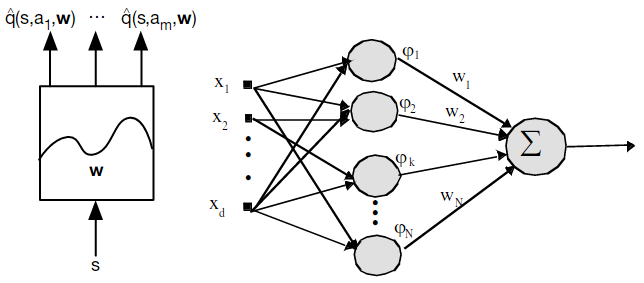

Using This architecture for function approximator.
- Input : States
- Output: Action Values [len(n_actions)]

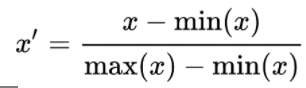

Before passing in the states to the neural network, it's best practice to normalize the states. We can do this by scaling with **Min-Max Normalization**

Of course there's also Batch Norm for neural network. But am just trying to mimic this experiment.

In [2]:
class ANNFuncApprox(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.l3(x) # Fully connected layer, dont use activator
        return x 

class ANNFuncApproxWithBN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, output_size)
        
        self.bn1 = torch.nn.BatchNorm1d(hidden_size)
        self.bn2 = torch.nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
    # Linear -> batchNorm -> relu
    def forward(self,x):
        x = self.relu(self.bn1(self.l1(x)))
        x = self.l2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.l3(x) # Fully connected layer, dont use activator
        return x 

In [3]:
# TODO: create architecture to transfer GPU to CPU , vice versa.

class QNetAgent:
    def __init__(self, env, LR): 
        self.env = env
        # Setting up Neural Network Model
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.model = ANNFuncApprox(self.num_states, 24 ,self.num_actions)
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.loss_criterion = nn.MSELoss()
        
        # Setting up replay memory
        self.batch_size = 64
        self.memory_size = 10000
        self.memory = deque(maxlen = self.memory_size)
        
        # How many times we train the NN with a random batch size at the end of each episode/game_over
        self.training_iterations = 40
        
        # For Plotting
        self.steps_done = 0
        self.episode_durations = []
        self.avg_episode_duration = []
        self.epsilon_history = []
    
    # Behaviour Policy (e-greedy)
    # Target Policy (argmax)
    def select_action(self, state):
        """ Select Action Based on Epsilon-greedy Approach"""        
        if np.random.random() <= self.epsilon:
            chosen_action = np.random.choice(self.num_actions)
        else:
            self.model.eval()
            with torch.no_grad(): 
                """ALWAYS UNSQUEEZE Before NN"""
                state = torch.FloatTensor(state)
                # Testing if this gives me error. If i comment this. It didn't weirdly.
                state = state.unsqueeze(0) 
                action_values = self.model(state)
            chosen_action = torch.argmax(action_values).item()
            self.model.train()
        return chosen_action
    
    
    def run_episodes(self,num_episodes, start_epsilon, min_epsilon, discount_factor):
        self.epsilon = start_epsilon
        self.min_epsilon = min_epsilon
        self.gamma = discount_factor
        episodes = trange(num_episodes, desc="ep", leave=True)
        
        for ep in episodes:
            state = self.env.reset()
            #state = self.normalize_states(state)
            
            for t in itertools.count(): 
                # S, A
                action = self.select_action(state)
                next_state, reward , game_over, _ = self.env.step(action)
                #next_state = self.normalize_states(next_state)
                
                # Render the environment after applying the action
                """Show the render when u do gucci"""
                self.env.render() 
                
                # We give a negative reward for failing becauseeee
                # The environment didn't provide one.
                # As to provide the "stick" in the [carrot and stick] donkey problem
                # Carrot = reward, stick = punishment
                if game_over:
                    reward = -10
                    
                # Push experience into replay memory
                # SARS'A', Yeah but in non-linear A' is not passed in.
                self.memory.append((torch.FloatTensor(state),
                                    torch.tensor(action),
                                    torch.tensor(reward),
                                    torch.FloatTensor(next_state)
                                   ))
                # TODO training neural network
                self.train_step()
                
                if game_over:
                    # Decay Epsilon
                    self.epsilon = self.decay_epsilon(num_episodes, start_epsilon, min_epsilon)
                    # Plotting purposes
                    self.epsilon_history.append(self.epsilon)
                    self.episode_durations.append(t)
                    #print(numpy.max(self.episode_durations))
                    self.plot_durations(ep,num_episodes)
                    break
                
                # S = S'
                state = next_state
                if ep> 1:
                    episodes.set_description(desc=f"ep = [{ep}/{num_episodes}], steps = {t}/{np.max(self.episode_durations)}, epsilon: {self.epsilon}", refresh=True)
    
    
    def train_step(self):
        # Get batch samples from memory
        if len(self.memory) < self.batch_size:
            return
        
        for i in range(self.training_iterations):
            # minibatch is generated by random sampling from experience replay memory
            memory_sample = random.sample(self.memory, self.batch_size)
            batch_state, batch_action, batch_reward,batch_next_state = zip(*memory_sample)
            
            # extract experience information for the entire minibatch
            batch_state = torch.stack(batch_state)
            batch_action = torch.stack(batch_action).unsqueeze(1)
            batch_reward = torch.stack(batch_reward)
            batch_next_state = torch.stack(batch_next_state)
            
            # current Q values are estimated by NN for all actions
            current_q_values = self.model(batch_state).gather(1,batch_action) 
            
            # Expected Q values that are estimated from maximum Q values.
            # Use detach : [NO GRADIENT]
            max_next_q_values = self.model(batch_next_state).detach().max(1)[0]
            expected_q_values = batch_reward + (self.gamma * max_next_q_values)

            loss = self.loss_criterion(current_q_values,expected_q_values.unsqueeze(1))
            # backpropagation of loss for NN training
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            
    # Helper functions
    # 1 
    def decay_epsilon(self,max_episodes, initial_e = 1.0, final_e = 0.0):
        # You should always decay epsilon on the end of the episode, not the start
        """ 
        Decay epsilon based on a number of episodes
        Use the comment below, if we are like playing Snakes for example, for the number of games/episodes 
        are infinite. We might train for uncountable times, until it completes the game
        
        # self.epsilon = max(min_epsilon,self.epsilon*0.9999)
        """
        epsilon_decay = 1+np.log(final_e)/(0.6*max_episodes)
        e = self.epsilon*epsilon_decay
        return e
    
    
    # 2 
    def normalize_states(self,states):
        min_x = self.env.observation_space.low
        max_x = self.env.observation_space.high
        print(states.shape)
        norm_states = np.zeros(states.shape)
        for i in range(len(states)):
            assert (None == max_x[i]-min_x[i]),"the computation will be None, dont use this method to normalize states" 
            norm_states[i] = (states[i] - min_x[i])/(max_x[i]-min_x[i])
        #states = torch.from_numpy(norm_states).float()
        return torch.from_numpy(norm_states).float()
    
    
    # 3  Plotting
    # Maybe Just Maybe i should just code my own plots
    def plot_durations(self,epi,num_episodes): # Update the plot at the end of each episode ## (I)
        %matplotlib qt 
        # Update with popup
        #%matplotlib inline # Update without popup
        # Clear plots
        fig = plt.figure(1)
        fig.canvas.set_window_title("DQN Training Statistics")
        plt.clf()
        
        # Plot 1
        plt.subplot(1,2,1)
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(self.episode_durations)
        
        episode_durations = torch.FloatTensor(self.episode_durations)
        # Plot cumulative mean
        explore_ep_end = int(0.1*num_episodes)
        if len(episode_durations) >= explore_ep_end:
            means = episode_durations.unfold(0, explore_ep_end, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(explore_ep_end-1), means))
            plt.plot(means.numpy())
        
        # Plot 2
        plt.subplot(1,2,2)
        plt.title("Epsilon per Episode")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.plot(self.epsilon_history)
        
        # Show all plots and draw
        #plt.show(block=False)
        plt.draw()
        #plt.pause(0.0001)

In [4]:
env = gym.envs.make("CartPole-v1")
Sarsa = QNetAgent(env=env, LR=0.001)
Sarsa.run_episodes(num_episodes=1000 ,start_epsilon = 1.0, min_epsilon = 0.05, discount_factor=0.8)
# Now to test for the plotting and the game itself
# Nice
# Gawd its so slow
# Maybe If i add a negative reward for failing

ep = [999/1000], steps = 127/499, epsilon: 0.0067353342917064515: 100%|██████████| 1000/1000 [2:13:05<00:00,  7.99s/it]


### Syntax explanation
1. unsqueeze(1) - converts and vice versa for (0)
 to 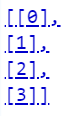

2. torch.stack - does sort of the same thing, but with a caveat

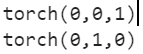 to 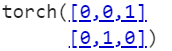




## Neural Network with Q Learning Important points


- Check for Catastrophe Clause - Neural Network doesn't learn because of sharing previous gradients.
- Carrot and stick donkey problem

#### To ensure Catastrophe Clause doesn't happen.
- At action - Make sure to predict using **torch.no_grad()**, **[model.eval]** 1 Example
- at training_function - **[model.train()]** Training with batches
    - Predict (current_q_values) with grad, **move** and previously made actions
    - predict expected_max_q_values with **copy** [.detach()] aka without grad.
    - loss = lossMSE(current_q_values, expected__max_q_values]

In a sense, we are using **Monte-Carlo** For this problem. by **training multiple times** at **each end of episode**. **Without TD. ** TD that trains at each timestep.
To Compute SARSA aka Monte-Carlo[compute when episode ends] + TD [Compute at each time-step]

We need to train at each timestep, and we need to train at the end of episode for random batches at multiple iterations.
- FULL ONLINE LEARNING.


#### To ensure Carrot and donkey Problem doesn't happen
We need to make sure the environment provides both the
- Carrot : **reward**
- Stick : **punishment/negative reward**
This may Seem Simple at first glance, but there are dumb environments that doesn't do this. a good exmple of this is...  "Cartpole-V1" Since it didn't provide a negative reward, we have to provide it for them.

### Neural Network 
#### Normalization
1. Normalize to 0-1 using the min max method shown above.
    - It's very good technique, but. It can cause some errors in computers by
        - min-max = 0 , if input/0, output becomes infinity
        - min-max is too large, the double variable is unable to store it.
2. Batch Normalization
    - By recognition, Batch normalization is very good as it normalizes any thing really well. Even when the Given input has a huge range of values, it performs well.

#### Forgetness versus Memory size
It is usual that ANN forgets things, just like a human does either by exploding gradients. But one should not mistake having incorrect batch_size/len_memory to exploding gradients.
In my current experiment, it appears that too big of memory has been used. So sometimes the neural network over-learns and update the gradients too much. Like for when i am at episode 100 but i am updating my weights using episode 1. 

- To counter forgetfulness: See Resnet and use DQN which saves the identity and image processing rather than a common Artificial Neural Network. DQN is also beautiful, u can literally train anything with just images alone just like how our brain does with receptive field.


#### Improvements Prioritize Experience Replay
Rather than training at multiple iterations from the batch, it's more ideal to choose Which batches we should focus on to reduce CPU Complexity. That such is PER, Prioritize Experience Replay. If the thing is useless, we just toss it in the ditch, preventing us from even training it. This is very essential for **Non-linear Methods** in comparison to **Linear-Methods** . It is super neccessary for **Sparse reward systems** Like Mountain-climber environment.
- Linear Methods = Tile Coding
- Non-Linear Methods = Neural Network.

- Sparse reward system: Mountain Car , only 1 Positive reward if we did it.
- Dense reward system : Cart_pole problem, positivity all the way bruv.

## My result
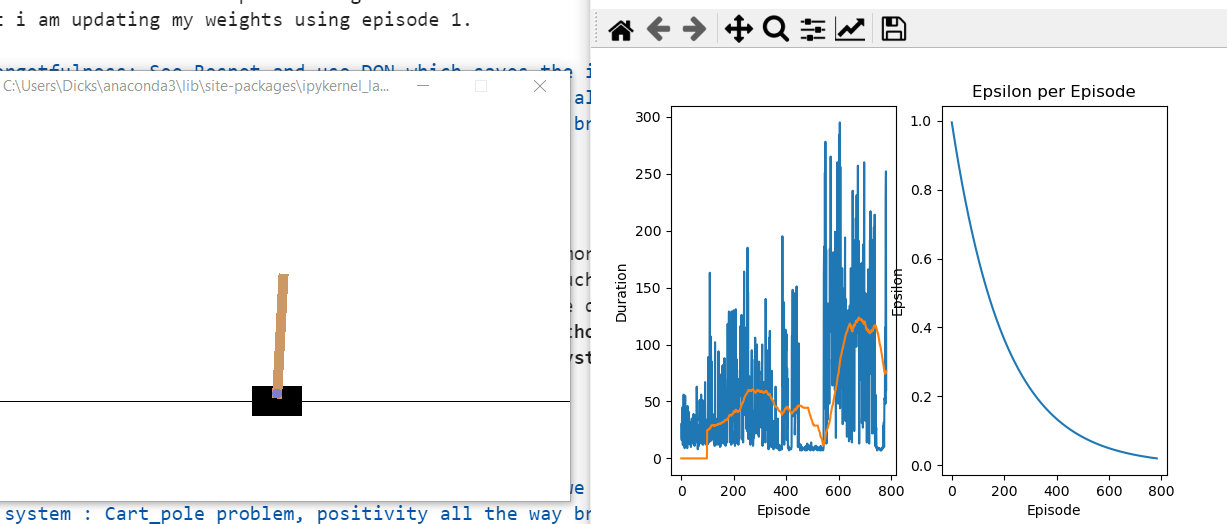
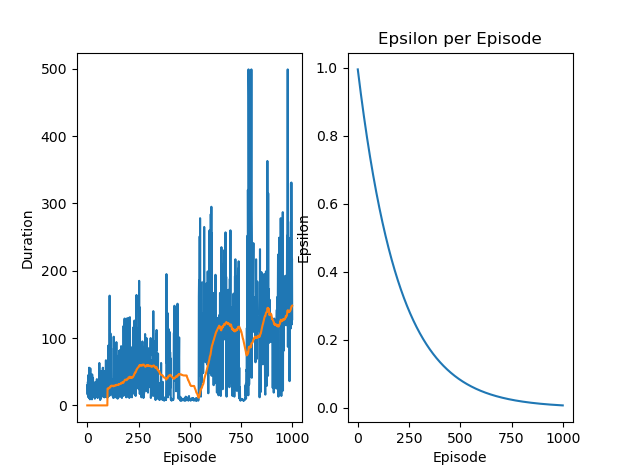

## Research paper result
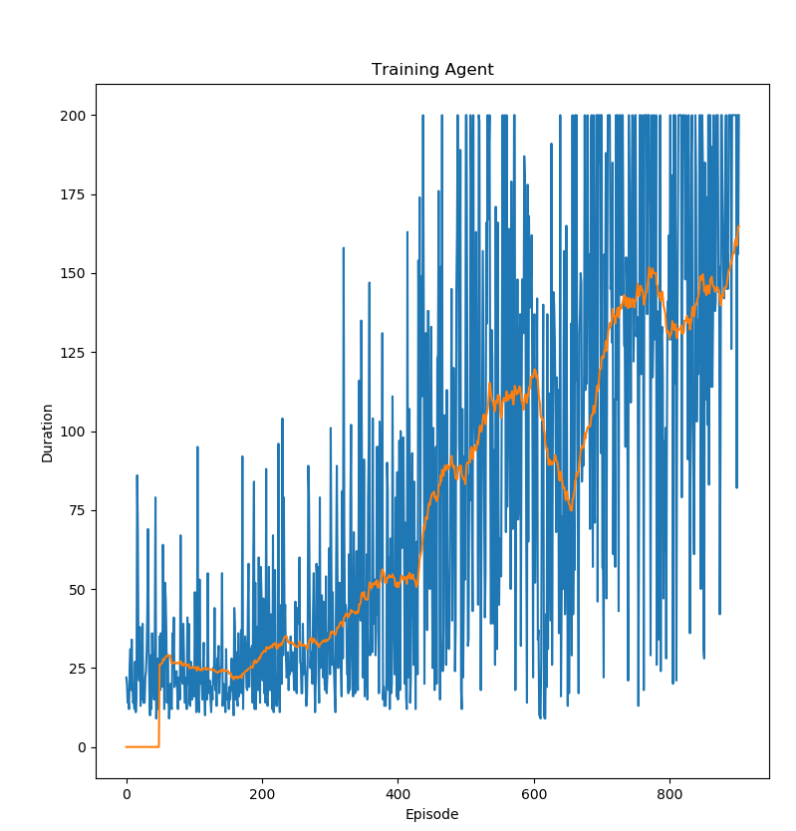

False
